# Code File for Baseline MoE and MoE with Monotonic Individual Experts
*Produce the figure, monotonicity score, average MSE, and standard error of MSE*


## Dependencies
*Make sure you are in the correct coding environment and import dependencies*

In [390]:
!which python3

# force reset
%reset -f 

/Users/yatingfang/Desktop/research/vir_env/temp/bin/python3


In [380]:
import sys

import GPy
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib.cm import get_cmap
from scipy.stats import multivariate_normal
from scipy.spatial.distance import mahalanobis

import math
import numbers
import logging
from pathlib import Path
import joblib
import numpy.random as npr
from scipy.special import logsumexp as lse
import matplotlib.pyplot as plt

from GPy.mappings import Linear

import os
import pickle
import copy
import scipy
import numpy
import time
import cvxpy as cp
from scipy.stats import t
import scipy.stats as stats
from scipy.stats import binom
from scipy.special import comb
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from scipy.interpolate import PchipInterpolator
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Helper Functions
*Run the following cells to define them*

In [381]:
def add_turbulence(arr, seed=1):
    """
    Function to add turbulence to duplicate elements
    """
    unique, counts = np.unique(arr, return_counts=True)
    duplicates = unique[counts > 1]
    
    for duplicate in duplicates:
        # Find all indices of the duplicate element
        indices = np.where(arr == duplicate)[0]
        # Add small random noise to all but the first occurrence
        for idx in indices[1:]:
            np.random.seed(seed) # if this is here, then we are always adding the same number
            arr[idx] += np.random.uniform(1e-10, 1e-9)  # small random noise
            
    return arr

def add_turbulence2(arr, seed=1):
    """
    Function to add turbulence to duplicate elements
    """
    np.random.seed(seed)
    
    unique, counts = np.unique(arr, return_counts=True)
    duplicates = unique[counts > 1]
    
    for duplicate in duplicates:
        # Find all indices of the duplicate element
        indices = np.where(arr == duplicate)[0]
        # Add small random noise to all but the first occurrence
        for idx in indices[1:]: 
            arr[idx] += np.random.uniform(1e-10, 1e-9)  # small random noise
            
    return arr

def test_add_turbulence():
    """
    Function to test the add_turbulence function
    """

    # Original array
    original_array = np.array([1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0])
    
    # Apply turbulence
    modified_array = add_turbulence(original_array.copy())
    
    print("Original array:", original_array)
    print("Modified array:", modified_array)

    return


In [382]:
class monotonic_poly:

    """
    Class for the BP polynomial model
    """

    def __init__(self, X, Y): 

        """
        X: (n, 1)
        Y: (n,)
        """

        self.X = X
        self.Y = Y
        self.deg = global_degree
        self.u_opt = np.zeros(self.deg+1)
        self.var = np.eye(self.deg+1) # variance-covariance matrix
        self.noise = 1 # will get updated in the function update_variance()

    def bernvander(self, x, deg):

        """
        the binomial pmf with "deg" trials and the probability given by "x"
        the berstein basis B(deg,x)
        returns a 2D array, a design matrix
        """
        
        return binom.pmf(np.arange(1 + deg), deg, x.reshape(-1, 1))

    def to_fit(self, indiv_mono_str="yes_mono"):

        x = self.X.reshape(-1)
        y = self.Y.reshape(-1)
                               
        deg = global_degree # define number of points and noise 
        alpha = global_alpha
        
        u = cp.Variable(deg + 1) # a placeholder for the optimal Bernstein coefficients
        loss = cp.sum_squares(self.bernvander(x, deg) @ u - y) # the sum of residual squares
        reg = alpha * cp.sum_squares(cp.diff(u, 2))       # penalty for 2nd order differences
        if indiv_mono_str == "yes_mono":
            constraints = [cp.diff(u) >= 0]                   # constraints - u_{i+1} - u_i >= 0
            problem = cp.Problem(cp.Minimize(loss + reg), constraints)
        else:
            problem = cp.Problem(cp.Minimize(loss + reg))
        
        problem.solve()
        #print(f'status: {problem.status}')
        u_opt = u.value

        # update
        self.deg = deg
        self.u_opt = u_opt
    
        return


    def to_predict(self, x_test):
        """
        Predict for new x using the current coefficients
        x_test: (n, 1)
        y_pred: (n,)
        """

        x_test = x_test.reshape(-1)

        y_pred = self.bernvander(x_test, self.deg) @ self.u_opt
        
        return y_pred

    def to_predict_var(self, x_test):

        """
        Give prediction uncertainty for new x 
        """

        x_test = x_test.reshape(-1)

        J = self.bernvander(x_test, self.deg)
        
        y_var = J @ self.var @ J.T + self.noise # add a noise to go from confidence interval to prediction interval

        # print(f'are they equal? {np.array_equal(J @ (self.var+self.noise) @ J.T, y_var)}')
        # print(f'one mean and std are {np.mean(J @ (self.var+self.noise) @ J.T)} and {np.std(J @ (self.var+self.noise) @ J.T)}')
        # print(f'another mean and std are {np.mean(y_var)} and {np.std(y_var)}')
        
        return y_var

    def current_score(self):
        """
        provide a measure of how good the current data fits the current model
        """

        x = self.X.reshape(-1)

        temp_pred = self.to_predict(x)
        
        temp_true = self.Y

        MSE = ((temp_true - temp_pred)** 2).mean()

        output = 1/(MSE+1e-16)
        
        return output


def test_poly():

    """
    simply testing the BP poly class
    """
    
    np.random.seed(42)
    x_train = np.sort(np.random.rand(100)).reshape(-1, 1)
    y_train = (2 * x_train).ravel() + 0.3 * np.random.randn(100)

    x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

    model = monotonic_poly(x_train, y_train)
    model.to_fit()

    y_pred = model.to_predict(x_test)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(x_train, y_train, label='Training data')
    plt.plot(x_test, y_pred, color='red', label='monotonic poly prediction')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Monotonic Poly Model')
    plt.show()

    return 


In [383]:
def unique_preserve_order(arr):
    """
    grab the unique elements from the array while preserving order
    """

    unique_dict = dict.fromkeys(arr) 
    # creates a new dictionary where the keys are the elements from arr
    # dictionary keys must be unique
    # In Python 3.7 and later, dictionaries maintain the order of insertion
    
    return np.array(list(unique_dict.keys()))

In [384]:
def update_variance(z, obsmodel):
    """
    This function updates the variance of a new BP model
    """
    
    # creates a new object that is a completely independent copy of the original
    z = copy.deepcopy(z)
    obsmodel = copy.deepcopy(obsmodel)

    unique_z = unique_preserve_order(z[z>=0])

    def binomial_prob(deg, i, x):
        """
        bionomial PMF for only i and only 1 x
        """

        output = comb(deg, i) * (x ** i) * ((1 - x) ** (deg - i))
            
        return output

    def obtain_coefficient_var(beta_hat, X, y_data):

        """
        y_data is the true response variable
        X is the design matrix
        beta_hat is the estimated coefficients
        """
    
        residuals = y_data - np.dot(X, beta_hat)
        rss = np.sum(residuals**2)
        
        n = len(y_data)
        p = len(beta_hat)
        
        sigma2_hat = rss / (n - p) # residual variance (n needs to be > p)
        matrix = np.dot(X.T, X) + 0.01*np.eye(X.shape[1])

        var_beta_hat = sigma2_hat * np.linalg.pinv(matrix) # coefficient uncertainty
        # The pseudoinverse is a generalization of the inverse matrix.
        # Not all matrices are invertible
        # so the pseudoinverse provides a way to obtain a matrix that behaves similarly to an inverse.
    
        return var_beta_hat, sigma2_hat

    for c in np.arange(unique_z.shape[0]): # two
    
        u = obsmodel[unique_z[c]].u_opt
        n = len(u)
        deg = n - 1

        x = obsmodel[unique_z[c]].X.reshape(-1)
        y = obsmodel[unique_z[c]].Y.reshape(-1)

        b = np.zeros((len(x), n))
        for i in np.arange(b.shape[0]):
            for k in np.arange(b.shape[1]):
                b[i,k] = binomial_prob(deg, k, x[i])
        
        var, sigma2_hat = obtain_coefficient_var(beta_hat=u, X=b, y_data=y)
        obsmodel[unique_z[c]].var = var
        obsmodel[unique_z[c]].noise = sigma2_hat

    return obsmodel


In [385]:
class MOBP:
    """
    Gibbs sampler, return expected cluster assignments and expert parameters
    """
    
    def __init__(self, X, Y,
                 alpha,
                 num_init_clusters=2, 
                 num_iter=100,
                 indiv_mono_str="yes_mono"): 

        self.X = X # (n,1)?
        self.Y = Y # (n)?
  
        self.alpha = alpha
        self.Nk = None # the number of points in each cluster (including empty clusters)
        self.N, _ = X.shape # the number of data points
        
        self.num_iter = num_iter
        self.num_init_clusters = num_init_clusters

        self.z = np.zeros(X.shape[0]) # cluster assignments
        self.p = dict()  
        self.obsmodel = dict()
        self.indiv_mono_str = indiv_mono_str


    def initialize_sampler(self, init_K):
        """
        initialize self.z and self.obsmodel
        """

        np.random.seed(0)
        x_data = self.X[:, 0].reshape(-1, 1) 
        
        initial_labels_ = np.concatenate([np.ones(global_first_cluster_size, dtype=int),
                                          np.zeros(len(x_data)-global_first_cluster_size, dtype=int)])
        self.z = initial_labels_
        
        for k in np.arange(len(np.unique(initial_labels_))):
            
            Xk = self.X[initial_labels_ == k]
            Yk = self.Y[initial_labels_ == k]
            self.obsmodel[k] = monotonic_poly(
                                     Xk[~np.isnan(Xk)].reshape(-1, 1), 
                                     Yk[~np.isnan(Yk)].reshape(-1, 1))
            self.obsmodel[k].to_fit(indiv_mono_str=self.indiv_mono_str)
        
        self.obsmodel = update_variance(self.z, self.obsmodel) # for all models


    def sample(self):

        self.initialize_sampler(init_K=self.num_init_clusters)

        self.Nk = np.bincount(self.z) # the number of points in each cluster (including empty clusters)
        
        idx = np.arange(self.N)
        print('Cluster Initialization: {}'.format(self.Nk[self.Nk > 0])) # the number of points in each cluster (excluding empty clusters)
        
        for l in np.arange(1, self.num_iter): # (inclusive, exclusive)
            for n in np.random.permutation(idx):

                """------------------- various updates ------------------------
                """
                
                curr_k = self.z[n] # save it, as self.z[n] will be changed
                if self.Nk[curr_k] == 1: # skip the point that is alone
                    continue

                # -------- moved here -----------------------                    

                # find the clusters that satisfy some conditions (only assign to these clusters)
                occupancy = np.hstack([self.Nk, self.alpha])
                temp_condition = (occupancy > 0) & (occupancy <= global_ub * self.X.shape[0]) & (occupancy >= global_lb * self.X.shape[0])
                active_comp_ids = np.where(temp_condition)[0]
                
                if len(active_comp_ids) > 0:
                    active_comp_ids = np.append(active_comp_ids, len(occupancy)-1) # still consider going to a new cluster

                if len(active_comp_ids) == 0: # skip this point if no cluster satisfies these conditions
                    continue 
                # -----------------------------------------------

                # remove the data point from the current cluster
                self.z[n] = -1 
                self.Nk[curr_k] -= 1
                
                if self.X[self.z == curr_k].shape[0] == 0: # if no point after the removal
                    self.obsmodel[curr_k] = None
                else: # still some points after the removal
                    # update the model
                    Xk = self.X[self.z == curr_k]
                    Yk = self.Y[self.z == curr_k] 
                    self.obsmodel[curr_k] = monotonic_poly(
                                     Xk[~np.isnan(Xk)].reshape(-1, 1), 
                                     Yk[~np.isnan(Yk)].reshape(-1, 1))
                    self.obsmodel[curr_k].to_fit(indiv_mono_str=self.indiv_mono_str)
                    self.obsmodel = update_variance(self.z, self.obsmodel)

                # create the new model as if the point will go there
                new_comp_model = monotonic_poly(
                                     self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1), 
                                     self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1))
                new_comp_model.to_fit(indiv_mono_str=self.indiv_mono_str)

                """ ------------------------------ end --------------------------------"""

                """ --------------- calculate the cluster probability ---------------"""

                def kernel(x, y, gamma=global_gamma):
                    return np.exp(-gamma * (x - y)**2)
                    
                def kernel_derivative(x, y, gamma=global_gamma):
                    return -2 * gamma * (x - y) * kernel(x, y, gamma)

                def a(x, S, T, gamma=global_gamma): # gating function
                    numerator = sum(kernel(x, xi, gamma) for xi in S)
                    denominator = sum(kernel(x, xi, gamma) for xi in T)
                    return numerator / denominator if denominator != 0 else 0

                def derivative_a(x, S, T, gamma=global_gamma): # derivative of gating function
                    sum_k_S = np.sum(kernel(x, S, gamma))
                    sum_k_T = np.sum(kernel(x, T, gamma))
                    sum_k_prime_S = np.sum(kernel_derivative(x, S, gamma))
                    sum_k_prime_T = np.sum(kernel_derivative(x, T, gamma))
                    numerator = sum_k_prime_S * sum_k_T - sum_k_S * sum_k_prime_T
                    denominator = sum_k_T**2
                    return numerator / denominator if denominator != 0 else 0

                # it returns a array of booleans where each entry is True if the corresponding element is NaN
                temp_x = self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1) # current point's x value

                # initialize score, which will help determine which cluster to go to
                temppp = 2*np.ones(self.Nk.shape[0], dtype=np.int64)
                score = np.hstack([np.log(temppp+1e-16), np.log(self.alpha+1e-16)])

                
                for i in np.arange(self.Nk.shape[0]): # go to each cluster (prob better to exclude empty ones, etc.)
                    
                    temp_S = self.X[self.z == i].reshape(-1,1) # the x values in that cluster
                    temp_temp = np.sum(kernel(temp_x, temp_S)) # closeness of the point to that cluster

                    # replace the initial value
                    if global_turbine == False:
                        score[i] = np.log(temp_temp+1e-16) 
                    else:
                        score[i] = temp_temp
                 
                if global_turbine == False:
                    # normalize
                    temp_arr = np.array(score)
                    score = (temp_arr - temp_arr.min()) / (temp_arr.max() - temp_arr.min()) # replace previous score
                else:
                    # a better way (assuming two experts)
                    temp_arr = np.array(score)[:-1]
                    temp_arr_max = temp_arr[np.argmax(temp_arr)]
                    temp_arr_min = temp_arr[np.argmin(temp_arr)]
                    temp_arr_diff = (temp_arr_max - temp_arr_min) / temp_arr_max # the smaller the percentage, the less of a difference
                    score[np.argmax(temp_arr)] = temp_arr_diff
                    score[np.argmin(temp_arr)] = 0.0

                for i in np.arange(self.Nk.shape[0]): 
                    score[i] = 5*score[i] # now ranges from 0-5
                    
                # -------------------------------- now consider the goodness of fit --------------------------------------
                fit_scores = []
                for k in active_comp_ids[:-1]: # only go through the clusters that satisfy the conditions
                    
                    temp_true = self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1) # y value of the current point
                    temp_pred = self.obsmodel[k].to_predict(self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1)) # predict for the current point
                    temp_score = 1/((((temp_true - temp_pred)** 2).mean())+1e-16) # a measure of the goodness of fit

                    if global_turbine == False:
                        fit_scores.append(np.log(float(temp_score)+1e-16)) # no longer a prob value
                    else:
                        fit_scores.append(float(temp_score))


                new_comp = active_comp_ids[-1]
                fit_scores.append(float(np.log(0*new_comp_model.current_score()+1e-16))) # supressed the new expert

                if global_turbine == False:
                    # noramlize
                    temp_arr = np.array(fit_scores)
                    fit_scores_updated = ((temp_arr - temp_arr.min()) / (temp_arr.max() - temp_arr.min())).tolist()

                else:
                    # a better way (assuming two experts)
                    fit_scores_updated = fit_scores
                    temp_arr = np.array(fit_scores_updated)[:-1]
                    temp_arr_max = temp_arr[np.argmax(temp_arr)]
                    temp_arr_min = temp_arr[np.argmin(temp_arr)]
                    temp_arr_diff = (temp_arr_max - temp_arr_min) / temp_arr_max # the smaller the percentage, the less of a difference
                    fit_scores_updated[np.argmax(temp_arr)] = temp_arr_diff
                    fit_scores_updated[np.argmin(temp_arr)] = 0.0


                temp_count = 0
                for k in active_comp_ids: 
                    score[k] += 5*fit_scores_updated[temp_count]
                    temp_count += 1
                
                final_score = score[active_comp_ids]

                # Directly computing sum of exp(a) can lead to numerical issues such as overflow or underflow
                # especially when the elements of a are very large or very small. 
                log_normalizing_constant = lse(final_score) # log of sum of exp(a)

                self.p[n] = np.exp(final_score - log_normalizing_constant) # exp(a) / sum of exp(a)

                # make the highest value 1 and everybody else 0
                temp_probs = np.zeros_like(self.p[n])
                temp_index = np.argmax(self.p[n])
                temp_probs[temp_index] = 1
                    
                """ ---------------------------------- end ------------------------------- """

                """ ---------------------------- updates ----------------------------
                """
                
                self.z[n] = npr.choice(active_comp_ids, p=temp_probs) # assign the current data point

                if self.z[n] > self.Nk.shape[0]-1: # if going to a new expert
                    self.Nk = np.hstack([self.Nk, 1])
                else: # if going to an existing expert
                    self.Nk[self.z[n]] += 1

                if self.z[n] == new_comp: # if going to a new expert
                    self.obsmodel[self.z[n]] = new_comp_model # add the new model
                else: # if going to an existing model
                    self.obsmodel[self.z[n]] = monotonic_poly(
                                     np.vstack([self.obsmodel[self.z[n]].X, self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1)]), 
                                     np.vstack([self.obsmodel[self.z[n]].Y, self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1)]))
                    self.obsmodel[self.z[n]].to_fit(indiv_mono_str=self.indiv_mono_str)
                    self.obsmodel = update_variance(self.z, self.obsmodel)

            """ ------ done looping data ----- """
                        
            # print information
            temp_active_comps = self.Nk[self.Nk > 0]
            print('Iter {}: {}'.format(l, temp_active_comps))

        """ ------ done looping iterations ---- """
        
#When you load a pickled instance, Python needs to be able to locate the class definition using the module 
#and class name that were stored when the objectwas pickled.
MOGP = MOBP

In [386]:
def generate_data():

    choice = global_choice
    np.random.seed(42)

    if choice == 112.5: # wavy

        x1 = np.linspace(0.1,0.45001,49)
        x1 = np.append(x1, 0.48)
        
        term = 3*np.pi*1.5*x1
        g_x = 1.05*(np.sin(term) + term)/(3*np.pi) + 1.0
        y1 = g_x + np.random.normal(0, 0.01, x1.size)

        #print(x1.shape)

        x2 = np.linspace(0.55727919,0.9,50)
        
        x_adjust = x2 - x2[0] 
        y_adjust = 1.780394386232395 
        y2 = y_adjust + 2.6e-6*x_adjust + np.random.normal(0, 0.01, x2.size)

        #print(x2.shape)

        #print('the intersection of the two model is (0.470251, 1.780394)')
        #print(f'the middle between the two data clusters is {x1[-1]/2 + x2[0]/2}')

        x_combined = np.concatenate([x1, x2]).reshape(-1,1)
        y_combined = np.concatenate([y1, y2])
    
        X = x_combined
        Y = y_combined


    elif choice == 200: # material science
        
        with open('data/mega_summ_stat_50bins.pkl', 'rb') as f:
            mega_summ_stat = pickle.load(f)

        summ_stat = mega_summ_stat[0]

        CF_xs = summ_stat[0]
        CF_ns = summ_stat[1]
        CF_means = summ_stat[2]
        CF_stds = summ_stat[3]
    
        DF_xs = summ_stat[4]
        DF_ns = summ_stat[5]
        DF_means = summ_stat[6]
        DF_stds = summ_stat[7]

        x1 = CF_xs
        x1 = x1[~np.isnan(x1)]
        x1 = (x1 - 0) / (70 - 0)
        #print(len(x1))
        
        SE = np.zeros(len(CF_stds))
        for i in range(0, len(CF_stds)):
            if CF_ns[i] == 0:
                SE[i] = np.nan
            else:
                SE[i] = CF_stds[i] / np.sqrt(CF_ns[i]) 

        y1 = np.random.normal(CF_means, SE)
        y1 = y1[~np.isnan(y1)]

        x2 = DF_xs
        x2 = x2[~np.isnan(x2)]
        x2 = (x2 - 0) / (70 - 0)
        #print(len(x2))

        SE = np.zeros(len(DF_stds))
        for i in range(0, len(DF_stds)):
            if DF_ns[i] == 0:
                SE[i] = np.nan
            else:
                SE[i] = DF_stds[i] / np.sqrt(DF_ns[i])

        y2 = np.random.normal(DF_means, SE)
        y2 = y2[~np.isnan(y2)]
        
        x_combined = np.concatenate([x1, x2]).reshape(-1,1)
        y_combined = np.concatenate([y1, y2])
    
        X = x_combined
        X = add_turbulence2(X.reshape(-1).copy()).reshape(-1,1)
        Y = y_combined


    elif choice == 304.555: # turbine
        
        df = pd.read_pickle('data/turbine167_seed42_1000_leave_over.pkl')
        
        x = np.array(df.iloc[:,0])
        x = (x - 3.5) / (19.9 - 3.5) # normalize
        y = np.array(df.iloc[:,1])
        
        X = x.reshape(-1,1)
        X = add_turbulence(X.reshape(-1).copy()).reshape(-1,1)
        Y = y

        
    #print(X.shape, Y.shape)

    # Plot the data for visualization
    # plt.figure(figsize=(10, 6))
    # plt.scatter(X, Y, s=10)
    # plt.title('Generated Data')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()


    return X, Y

In [387]:
def generate_test(X, Y, c_test):

    """
    to generate test data
    note: 
     - do not use random_state of 42
     - should not alter X or Y

    """
    random_state = 1
    
    np.random.seed(random_state)


    if c_test == 1112: # test data for wavy

        X_test = []
        Y_test = []
        
        for test_i in range(0,30):
            
            true_threshold = 0.470251
            x1 = np.zeros(25)
            even_x1 = np.sort(np.random.uniform(0.1,true_threshold-0.0001,x1.size)) 

            np.random.normal(0, 0.01, x1.size) # for reproducibility
            
            term = 3*np.pi*1.5*even_x1 
            g_x = 1.05*(np.sin(term) + term)/(3*np.pi) + 1.0
            y1 = g_x + np.random.normal(0, 0.01, even_x1.size)

            x2 = np.zeros(25)
            even_x2 = np.sort(np.random.uniform(true_threshold+0.0001,0.9,x2.size))
            
            x_adjust = even_x2 - 0.55727919
            y_adjust = 1.780394386232395 
            y2 = y_adjust + 2.6e-6*x_adjust + np.random.normal(0, 0.01, even_x2.size)
            
            x_combined = np.concatenate([even_x1, even_x2]).reshape(-1,1)
            y_combined = np.concatenate([y1, y2])
        
            X_test_current = x_combined
            Y_test_current = y_combined

            X_test.append(X_test_current)
            Y_test.append(Y_test_current)

    elif c_test == 1200: # test data for material science

        X_test = []
        Y_test = []

        for test_i in range(0,30):
        
            with open('data/mega_summ_stat_50bins.pkl', 'rb') as f:
                mega_summ_stat = pickle.load(f)
    
            summ_stat = mega_summ_stat[0]
    
            CF_xs = summ_stat[0]
            CF_ns = summ_stat[1]
            CF_means = summ_stat[2]
            CF_stds = summ_stat[3]
        
            DF_xs = summ_stat[4]
            DF_ns = summ_stat[5]
            DF_means = summ_stat[6]
            DF_stds = summ_stat[7]
    
            x1 = CF_xs
            x1 = x1[~np.isnan(x1)]
            x1 = (x1 - 0) / (70 - 0) + np.random.normal(0,0.0001,x1.size)
            x1[x1 < 0] = 0
            x1[x1 > 1] = 1
            #print(len(x1))
            
            SE = np.zeros(len(CF_stds))
            for i in range(0, len(CF_stds)):
                if CF_ns[i] == 0:
                    SE[i] = np.nan
                else:
                    SE[i] = CF_stds[i] / np.sqrt(CF_ns[i]) 
    
            y1 = np.random.normal(CF_means, SE)
            y1 = y1[~np.isnan(y1)]
    
            x2 = DF_xs
            x2 = x2[~np.isnan(x2)]
            x2 = (x2 - 0) / (70 - 0) + np.random.normal(0,0.0001,x2.size)
            x2[x2 < 0] = 0
            x2[x2 > 1] = 1
            #print(len(x2))
    
            SE = np.zeros(len(DF_stds))
            for i in range(0, len(DF_stds)):
                if DF_ns[i] == 0:
                    SE[i] = np.nan
                else:
                    SE[i] = DF_stds[i] / np.sqrt(DF_ns[i])
    
            y2 = np.random.normal(DF_means, SE)
            y2 = y2[~np.isnan(y2)]
            
            x_combined = np.concatenate([x1, x2]).reshape(-1,1)
            y_combined = np.concatenate([y1, y2])
        
            X_test_current = x_combined
            X_test_current = add_turbulence2(X_test_current.reshape(-1).copy()).reshape(-1,1)
            Y_test_current = y_combined

            indices = np.random.choice(len(X_test_current), size=10, replace=False)

            X_test.append(X_test_current[indices])
            Y_test.append(Y_test_current[indices])


    elif c_test == 1304: # test data for turbine

        with open("data/turbine167_many_seeds_110_stratified_cleaned.pkl", "rb") as f:
            # Load the pickled list from the file
            df_list = pickle.load(f)

        X_test = []
        Y_test = []

        for df in df_list:

            df = df[df.iloc[:, 0] <= 19.9]
            
            x = np.array(df.iloc[:,0])
            x = (x - 3.5) / (19.9 - 3.5) # normalize in the same way
            y = np.array(df.iloc[:,1])
            
            X_test_current = x.reshape(-1,1)
            X_test_current = add_turbulence(X_test_current.reshape(-1).copy()).reshape(-1,1)
            Y_test_current = y

            X_test.append(X_test_current)
            Y_test.append(Y_test_current)


    X_train = X
    Y_train = Y

    # Plot the data for visualization
    # plt.figure(figsize=(10, 6))
    
    # if isinstance(X_test, list) != True:
    #     plt.scatter(X_test, Y_test, s=10)
    # else:
    #     plt.scatter(X_test[0], Y_test[0], s=10)
        
    # plt.title('Generated Data')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()


    return X_train, X_test, Y_train, Y_test
    

In [388]:
def visualize_result2(mixing, mixed_X, mixed_Y, clusters_X=None, clusters_Y=None, mixed_X_test=None, mixed_Y_test=None):

    """
    mixed_X_test, mixed_Y_test: optional testing data to predict for, otherwise we are using testing values across the domain
    
    """
    X = np.linspace(0,1,1000).reshape(-1,1) # the x values across the domain to predict for
    Y_true = None

    if mixed_Y_test is not None:
        temp_index = np.argsort(mixed_X_test.reshape(-1))
        X = mixed_X_test[temp_index].reshape(-1,1) # sorted testing x values
        Y_true = mixed_Y_test[temp_index] # sorted testing y values
    
    z = mixing.z
    unique_z = unique_preserve_order(z)
    
    # clustering metrics
    # data_2D = np.concatenate((mixed_X, mixed_Y.reshape(-1,1)), axis=1)
    # dbi = davies_bouldin_score(data_2D, mixing.z)
    # print(f'Davies-Bouldin Index: {dbi}')
    # true_labels = np.concatenate([np.ones(42, dtype=int),np.zeros(44, dtype=int)])
    # ari_metric = adjusted_rand_score(true_labels, mixing.z)
    # print(f'Adjusted Rand Index (ARI): {ari_metric}')

    means_matrix = [] # pred means from all models
    vars_matrix = [] # pred variances from all models
    for i in np.arange(unique_z.shape[0]):
        
        mean = mixing.obsmodel[unique_z[i]].to_predict(X)
        means_matrix.append(mean.reshape(-1))
        
        var = mixing.obsmodel[unique_z[i]].to_predict_var(X)
        var = np.diag(var)
        vars_matrix.append(var.reshape(-1))


    def kernel(x, y, gamma=global_gamma):
        return np.exp(-gamma * (x - y)**2)
    
    weights_matrix = [] # the closeness of all test points to all clusters, # test points by # clusters
    
    for x in X:
        raw_weights = [] # the closeness of current test point to all clusters
        for i in np.arange(unique_z.shape[0]):

            current_set = mixed_X[mixing.z == unique_z[i],:].reshape(-1) # the x values from this cluster
            temp_weight1 = np.sum(kernel(x, current_set)) # the closeness of current test point to the cluster
            raw_weights.append(temp_weight1)

        normalizing_constant = np.sum(raw_weights) 
        weights = raw_weights / (normalizing_constant)
        
        weights_matrix.append(weights)

    gate_to_plot = [float(element[0]) for element in weights_matrix]
    
    weighted_means = [] # mixture prediction
    weighted_vars = []
    for i in range(len(X)): 
        
        weights = weights_matrix[i] # the closeness of current test point to all clusters
        weights_vars = [item**2 for item in weights] 

        model_means = [model[i] for model in means_matrix] # prediction for this test point from each model
        model_vars = [model[i] for model in vars_matrix] 

        weighted_means.append(float(sum([a * b for a, b in zip(model_means, weights)]))) 
        weighted_vars.append(float(sum([a * b for a, b in zip(model_vars, weights_vars)])))  
    
    actual_y = weighted_means
    
    def quantifiable_results(y_true, y_pred, x):

        x = x.reshape(-1) # test x 
        y_pred = np.array(y_pred) # predicted y value for the test x

        if y_true is not None: # the true y value for the test x
            y_true = np.array(y_true)
            mse = mean_squared_error(y_true, y_pred)
            mae = None
            r2 = None
        else:
            mse = None
            mae = None
            r2 = None

        y_pred_rounded = np.round(y_pred, decimals=5)
        correlation, _ = spearmanr(x, y_pred_rounded)
        monotonicity_score = correlation

        if mixed_X_test is None:
            print(f"Monotonicity Score: {monotonicity_score}")

        return mse, mae, r2

    mse, mae, r2 = quantifiable_results(Y_true, actual_y, X)
    
    weighted_stds = [np.sqrt(item) for item in weighted_vars] # mixture prediction standard deviation

    lbs = [weighted_means[i] - 1.96 * weighted_stds[i] for i in range(len(X))] # mixture prediction means as the center
    ubs = [weighted_means[i] + 1.96 * weighted_stds[i] for i in range(len(X))]


    return [X, actual_y, Y_true, mse, mae, r2, gate_to_plot, lbs, ubs]
    

In [389]:
def visualize_result(z, mixed_X, mixed_Y, clusters_X=None, clusters_Y=None, option="both + mixture_pred", plot_mixture_pred=None, case_study="wavy", save_file=False):

    """
    mixed_X and mixed_Y are the training data 
    
    """

    unique_z = unique_preserve_order(z) 
    
    means = [] # predictions for all sorted training x values, from each model
    vars = []
    sub_means = [] # predictions for sorted training x values from each cluster, from corresponding model
    sub_vars = []
    
    sub_Xs = [] # list of training x values from each cluster (sorted)
    sub_Xs_original = [] # list of training x values from each cluster (without sorting)
    sub_Ys_original = []
    
    entire_X = np.sort(mixed_X.reshape(-1,1), axis=0) # sorted training x values (from all clusters)
    entire_X_original = mixed_X.reshape(-1,1) # without sorting
    entire_Y_original = mixed_Y.reshape(-1,1) 
    
    for i in np.arange(unique_z.shape[0]):
        
        index = np.where(z == unique_z[i])[0]

        # all the data points of a particular cluster
        X = np.sort(mixed_X[index].reshape(-1,1), axis=0) # sorted training x values from this cluster
        X_original = mixed_X[index].reshape(-1,1) # without sorting
        Y_original = mixed_Y[index].reshape(-1,1) # without soting
        sub_Xs_original.append(X_original)
        sub_Ys_original.append(Y_original)
        
        if X[~np.isnan(X)].shape[0] > 0:
            
            mean = mixing.obsmodel[unique_z[i]].to_predict(entire_X) 
            means.append(mean)
            
            sub_Xs.append(X)
            sub_mean = mixing.obsmodel[unique_z[i]].to_predict(X)
            sub_means.append(sub_mean)

            sub_var = mixing.obsmodel[unique_z[i]].to_predict_var(X)
            sub_vars.append(np.diag(sub_var))
        
    if plot_mixture_pred is not None:

        plt.close()
        colors = ['#ADD8E6','#FFC87C']
        shapes = ['o', 's']
        linestyles = ['--','-.']
        
        plt.style.use('default')
        plt.figure(figsize=(10, 6), dpi=300)
        
        plt.xlabel('X', fontsize=22, labelpad=10)  
        plt.ylabel('Y', fontsize=22, labelpad=10) 
        
        plt.xticks(fontsize=20) 
        plt.yticks(fontsize=20) 

        # extract from the input
        mixture_X = plot_mixture_pred[0]
        mixture_Y = plot_mixture_pred[1]
        mixture_Y_true = plot_mixture_pred[2]
        gate_to_plot = plot_mixture_pred[6]
        lbs = plot_mixture_pred[7]
        ubs = plot_mixture_pred[8]

        if case_study == "turbine":
            mixture_X = mixture_X*(19.9-3.5)+3.5
            sub_Xs_original = [item*(19.9-3.5)+3.5 for item in sub_Xs_original]

        # Plot each data subset with distinct colors and markers
        
        for i in np.arange(unique_z.shape[0]):
            i_replace = i
            if case_study == "material_sci":
                i_replace = i-1
            plt.scatter(
                sub_Xs_original[i_replace], sub_Ys_original[i_replace], # list of training points from each cluster (without sorting)
                label=f'Assigned data for expert {i+1}', 
                color=colors[i],  
                marker=shapes[i],
                alpha=0.85,  # Slight transparency for clarity
                s=60,  # Larger markers for better visibility
            )
        
        # Plot the mean prediction line
        plt.plot(
            mixture_X, mixture_Y,
            label='Mixture Prediction', color='black',
            linewidth=2.5, linestyle='-', alpha=0.9
        )

        # Plotting the prediction interval
        plt.fill_between(mixture_X[:, 0], 
                         lbs, 
                         ubs, 
                         alpha=0.5,  
                         color='lightgrey', 
                         label='95% Mixture Prediction Interval') 
        
        # Optionally, add dashed lines to highlight the bounds of the interval
        # *(19.9-3.5)+3.5
        plt.plot(mixture_X[:, 0], lbs, color='gray', linestyle='--', linewidth=1.5)  # Lower bound
        plt.plot(mixture_X[:, 0], ubs, color='gray', linestyle='--', linewidth=1.5)  # Upper bound
        

        if case_study == "material_sci":
            leg_loc = 'upper left'
        else:
            leg_loc = 'lower right'
            
        plt.legend(
            loc=leg_loc, borderaxespad=1, # the padding between the legend’s border and the axes
            prop={'size': 19},  
            markerscale=1.5, # scales the marker size in the legend relative to their original size in the plot
            frameon=True, 
            framealpha=0.8,  
            facecolor='white',  
            edgecolor='grey'   
        )
        
        plt.tight_layout() # for minimal white space

        if case_study == "wavy":
            plt.ylim(1.1,2.01)
            plt.xlim(0.09,0.91)

        if case_study == "material_sci":
            plt.ylim(-15,55)
            plt.xlim(0,0.95)

        if case_study == "turbine":
            plt.ylim(-0.3,1.3)
            plt.xlim(3.5,19.3)

        if save_file == True:
            plt.savefig('publication_figures/'+case_study+'_baseline_'+indiv_mono_str+'.png', dpi=300, bbox_inches='tight')
        
        plt.show()

    return
    
    

## Function Calls and Results
*Choose the dataset and model to see the corresponding figure, monotonicity score, average MSE, and standard error of MSE*
- *Dataset choices: ```"wavy"``` for synthetic data, ```"material_sci"```, and ```"turbine"```*
- *Model choices: ```"no_mono"``` for Baseline MoE and ```"yes_mono"``` for MMIE*
- *Results will appear in the output, set ```save_file``` to be ```True``` if wishing to save the figure to the ```publication_figures/``` folder*

In [ ]:
# configure
indiv_mono_str = "yes_mono"
case_study = "material_sci"
save_file = False

Cluster Initialization: [42 44]
Iter 1: [52 34]
Iter 2: [52 34]
Iter 3: [52 34]
Iter 4: [52 34]
time took: 2.326601982116699 seconds
Monotonicity Score: 0.9951393731018072
average mse over 30 seeds is 5.6567252901563405
SE of mse is 0.010013662722945382


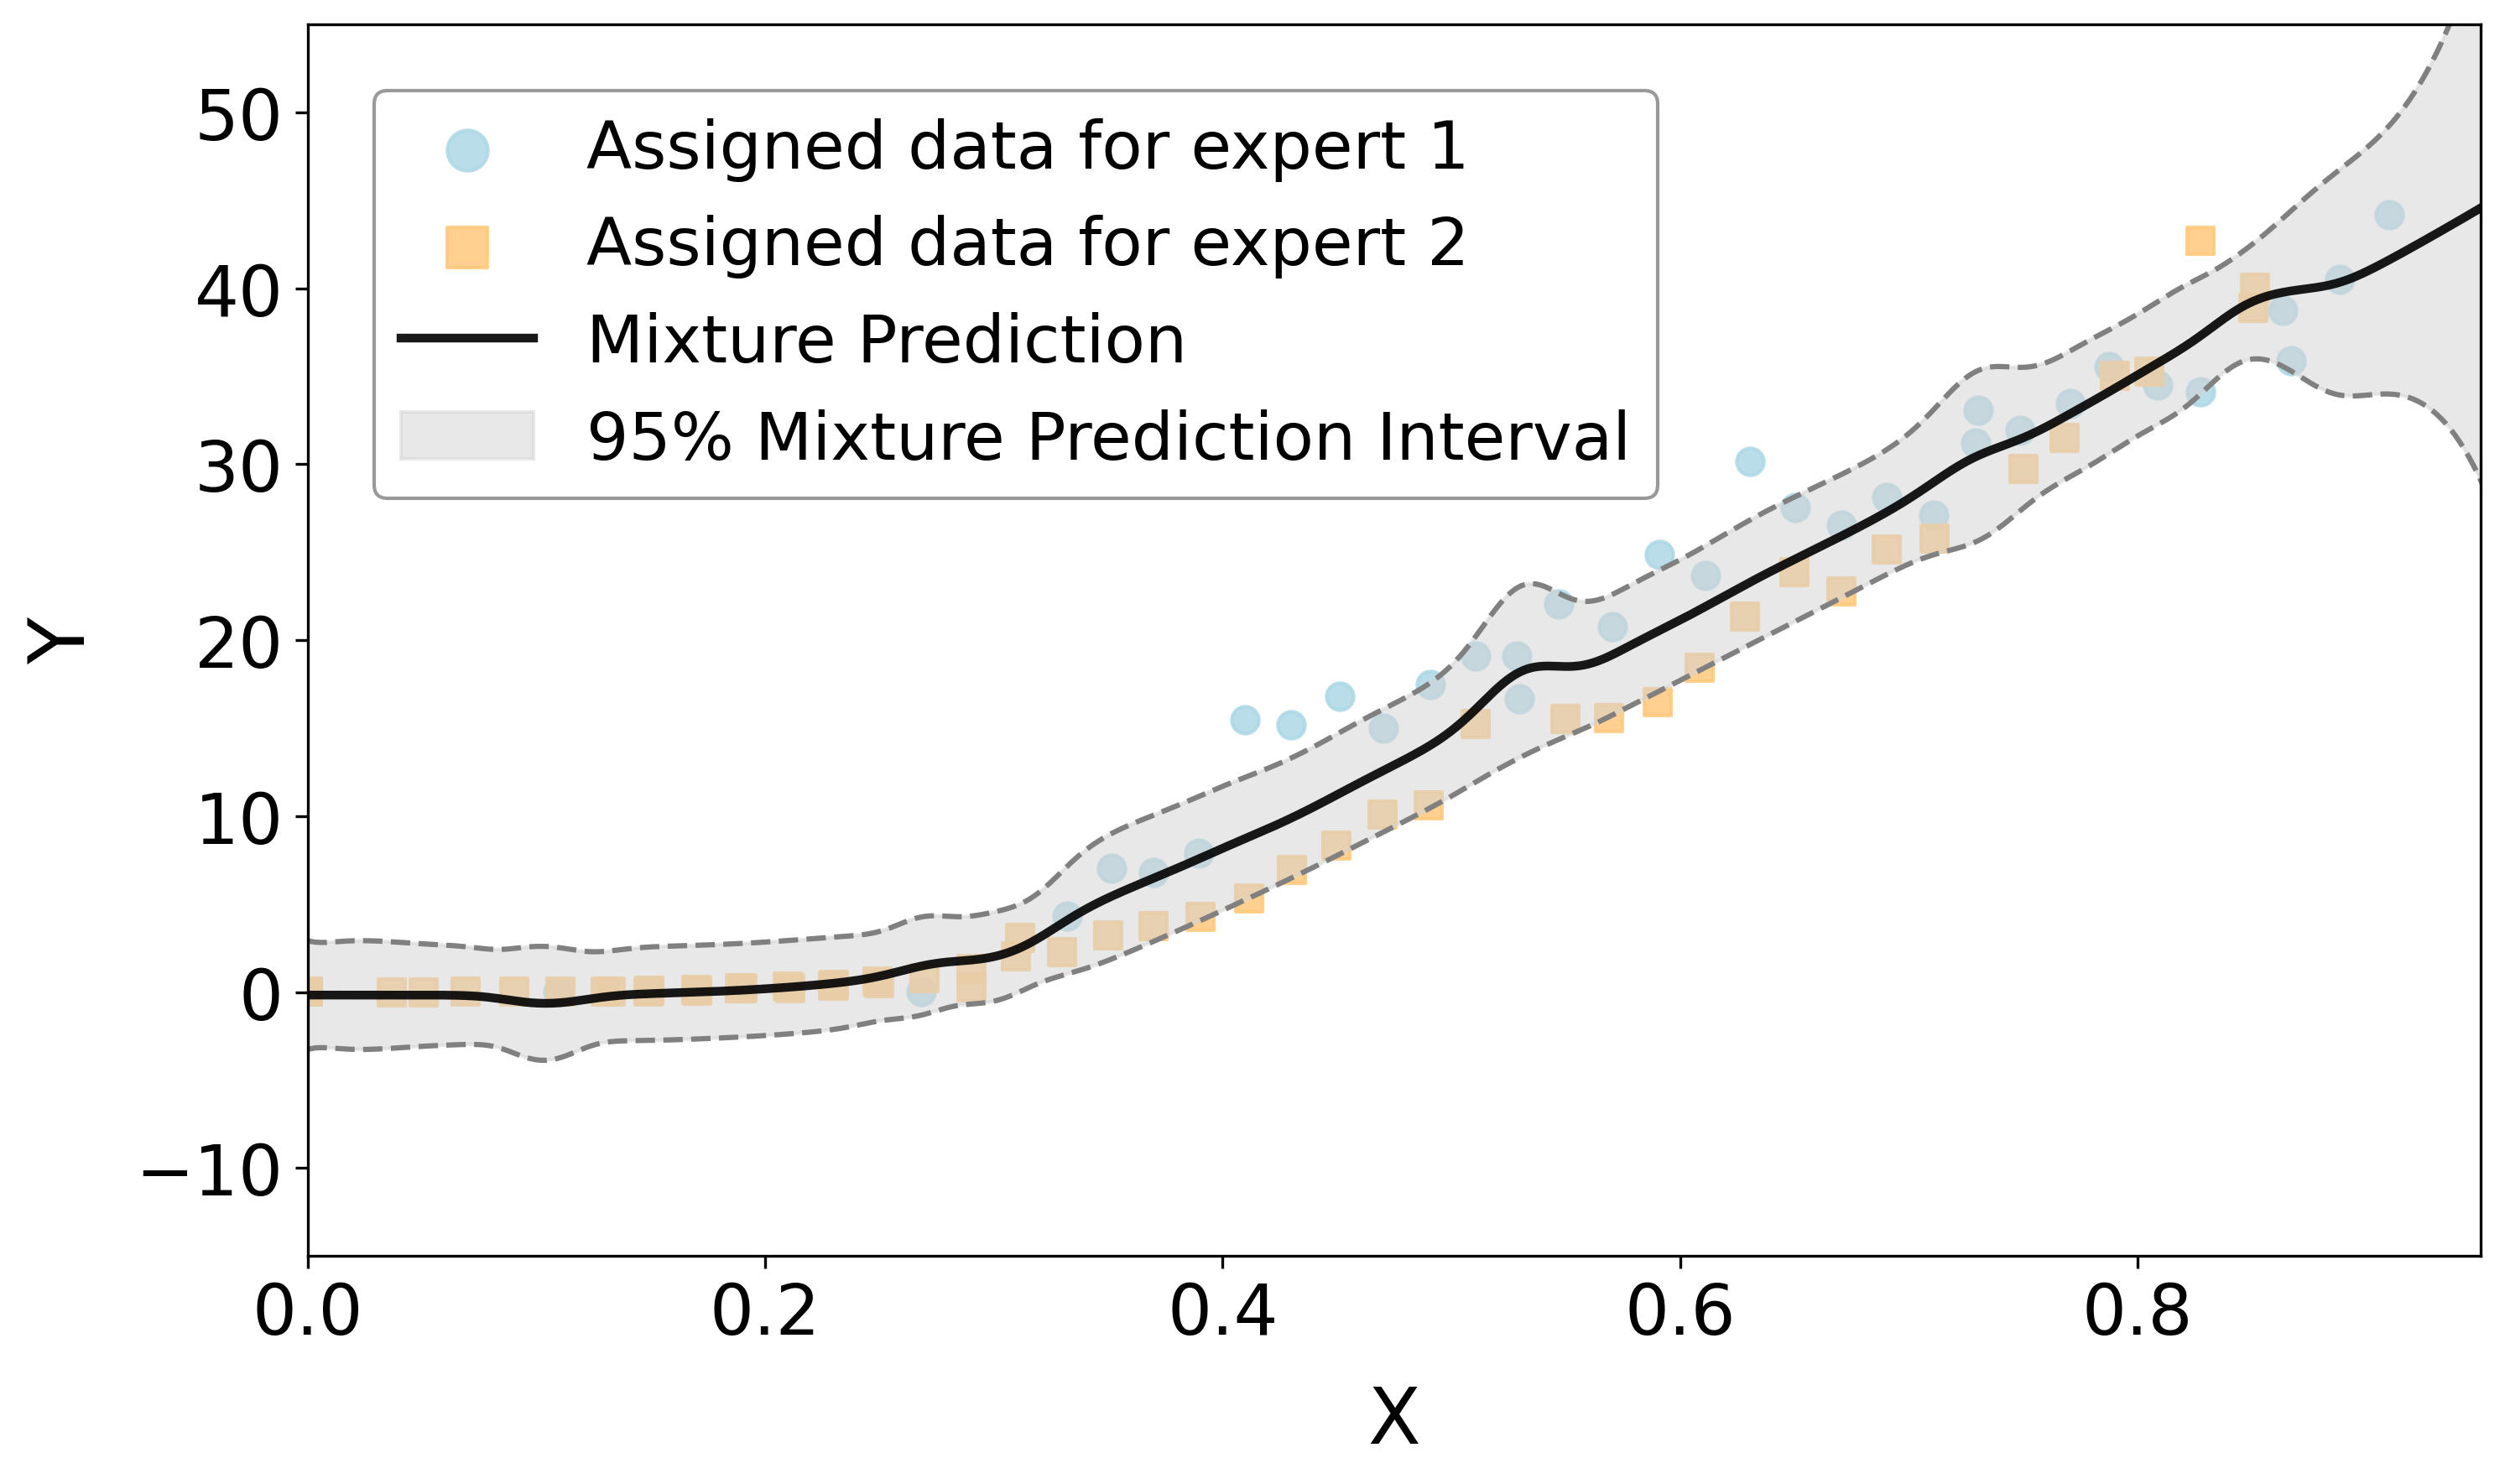

In [375]:
# run to generate results
if case_study == "material_sci":
    global_gamma = 2000
    global_choice = 200
    global_c_test = 1200
    global_first_cluster_size = 44
    global_degree = 20
    global_alpha = 2
    global_num_iter = 5
    global_ub = 0.6
    global_lb = 0.4
    global_turbine = False
elif case_study == "wavy":
    global_gamma = 5000
    global_choice = 112.5
    global_c_test = 1112
    global_first_cluster_size = 50
    global_degree = 40
    global_alpha = 0.5
    global_num_iter = 5
    global_ub = 0.7
    global_lb = 0.4
    global_turbine = False
elif case_study == "turbine":
    global_gamma = 5000
    global_choice = 304.555
    global_c_test = 1304
    global_first_cluster_size = 425
    global_degree = 15
    global_alpha = 2
    global_num_iter = 20
    global_ub = 0.7
    global_lb = 0.3
    global_turbine = True


# generate training data
mixed_X, mixed_Y = generate_data()
# generate test data
mixed_X_train, mixed_X_test, mixed_Y_train, mixed_Y_test = generate_test(mixed_X, mixed_Y, global_c_test)
# initialize the mixture model
mixing = MOBP(X=mixed_X_train, Y=mixed_Y_train, alpha=0, num_init_clusters=2, num_iter=global_num_iter, indiv_mono_str=indiv_mono_str) 
# fit the mixture model
if case_study != "turbine":
    temp_start = time.time()
    mixing.sample()
    temp_end = time.time()
    print(f'time took: {temp_end - temp_start} seconds')
else:
    with open("baseline_fitted_models/"+indiv_mono_str+"_T167_IN425_leave_over.pkl", "rb") as f:
        mixing = pickle.load(f)

# generate what is needed for figure
plot_items = visualize_result2(mixing, mixed_X_train, mixed_Y_train, mixed_X_test=None, mixed_Y_test=None)

# generate the metrics
total_num_seeds = len(mixed_X_test)
mse_list = []

for test_i in range(0, total_num_seeds):
    plot_items_ = visualize_result2(mixing, mixed_X_train, mixed_Y_train, mixed_X_test=mixed_X_test[test_i], mixed_Y_test=mixed_Y_test[test_i])
    mse_list.append(plot_items_[3])
    
print(f'average mse over {total_num_seeds} seeds is {sum(mse_list)/total_num_seeds}')
print(f'SE of mse is {np.std(mse_list)/np.sqrt(total_num_seeds)}')

# generate the figure
visualize_result(mixing.z, mixed_X_train, mixed_Y_train, option='both + mixture_pred', plot_mixture_pred=plot_items, case_study=case_study, save_file=save_file)
